# Assignment 1
<!-- Understanding and implementing SLIC Superpixels. -->
A superpixel can be defined as a group of pixels that share common characteristics. Simple Linear Iterative Clustering (SLIC) generates superpixels by clustering pixels based on their color similarity and proximity in the image plane. The purpose of this assignment is to understand and implement SLIC Superpixels.

Some pointers before we start:
- Please follow all submission guidlines which are posted on piazza.
- Ensure all outputs are displayed while rendering the PDF.
- Only modify the code blocks  which has a "TODO".
- Below you can see some outputs for an image of a cow. These images represent the kind of output that is expected. 
- Feel free to reach out to any of the TAs for any doubts/issues.

Let's download the dataset first.

We only focus on six images in this assignment.

In [1]:
im_list = ['MSRC_ObjCategImageDatabase_v1/1_22_s.bmp',
           'MSRC_ObjCategImageDatabase_v1/1_27_s.bmp',
           'MSRC_ObjCategImageDatabase_v1/3_3_s.bmp',
           'MSRC_ObjCategImageDatabase_v1/3_6_s.bmp',
           'MSRC_ObjCategImageDatabase_v1/6_5_s.bmp',
           'MSRC_ObjCategImageDatabase_v1/7_19_s.bmp']

In [2]:
#All important functions to plot, do not modify this block
%matplotlib inline
import cv2
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as mpatches

def plot_image(im,title,xticks=[],yticks= [],isCv2 = True):
    """
    im :Image to plot
    title : Title of image 
    xticks : List of tick values. Defaults to nothing
    yticks :List of tick values. Defaults to nothing 
    cv2 :Is the image cv2 image? cv2 images are BGR instead of RGB. Default True
    """
    plt.figure()
    if isCv2:
        im = im[:,:,::-1]
    plt.imshow(im)
    plt.title(title)
    plt.xticks(xticks)
    plt.yticks(yticks)

def superpixel_plot(im,seg,title = "Superpixels"):
    """
    Given an image (nXmX3) and pixelwise class mat (nXm), 
    1. Consider each class as a superpixel
    2. Calculate mean superpixel value for each class
    3. Replace the RGB value of each pixel in a class with the mean value  
    
    Inputs:
    im: Input image
    seg: Segmentation map
    title: Title of the plot 
    
    Output: None
    Creates a plot    
    """
    clust = np.unique(seg)
    mapper_dict = {i: im[seg == i].mean(axis = 0)/255. for i in clust}

    seg_img =  np.zeros((seg.shape[0],seg.shape[1],3))
    for i in clust:
        seg_img[seg == i] = mapper_dict[i]
    
    plot_image(seg_img,title)
    
    return    

def rgb_segment(seg,n = None,plot = True,title=None,legend = True,color = None):
    """
    Given a segmentation map, get the plot of the classes
    """
    clust = np.unique(seg)
    if n is None:
        n = len(clust)
    if color is None:
        cm = plt.cm.get_cmap('hsv',n+1)
        # mapper_dict = {i:np.array(cm(i/n)) for i in clust}
        mapper_dict = {i:np.random.rand(3,) for i in clust} 
    #elif color == 'mean':
        #TODO..get the mean color of cluster center and assign that to mapper_dict

    seg_img =  np.zeros((seg.shape[0],seg.shape[1],3))
    for i in clust:
        seg_img[seg == i] = mapper_dict[i][:3]

    if plot: 
        plot_image(seg_img,title = title)
    if legend:
        # get the colors of the values, according to the 
        # colormap used by imshow
        patches = [ mpatches.Patch(color=mapper_dict[i], label=" : {l}".format(l=i) ) for i in range(n) ]
        # put those patched as legend-handles into the legend
        plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0. )
        plt.grid(True)
        plt.show()

    return seg_img

Let's see what the six images are:

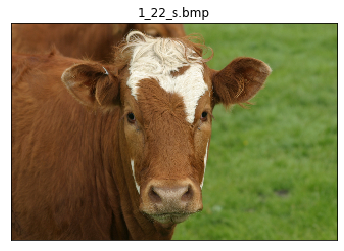

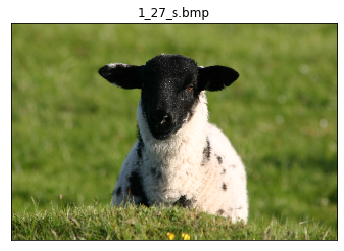

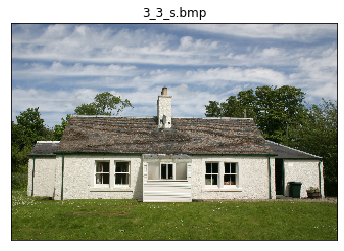

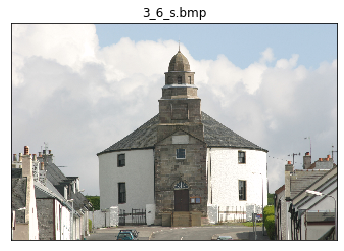

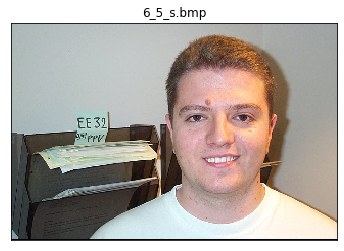

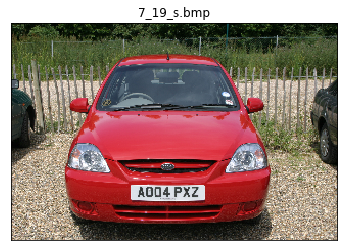

In [3]:
for i in im_list:
    plot_image(cv2.imread(i),i.split("/")[-1])

Get image and visualize it. Its a scenery with 3 elements. You can see the segmentation ground truth in the GT bitmap.  

127

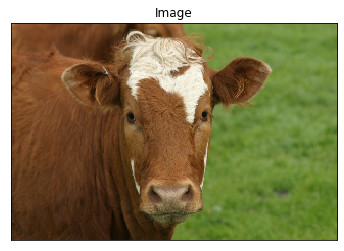

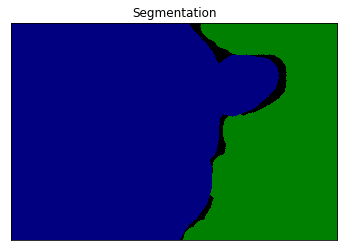

In [32]:
import PIL

im = cv2.imread(im_list[0])
seg = cv2.imread(im_list[0].replace("_s","_s_GT"))
x_coord, y_coord = np.meshgrid(np.linspace(0, im.shape[0]-1, num = im.shape[0], dtype = int), 
                                   np.linspace(0, im.shape[1]-1, num = im.shape[1], dtype = int), 
                                   indexing = 'ij')
# Concatenate depth wise
image = np.stack((im[:,:,0],im[:,:,1], im[:,:,2], x_coord, y_coord), axis = 2)

plot_image(im,"Image")
plot_image(seg,"Segmentation")
image[0,0,:][1]

###Question 1: K-means on RGB
We know k-means clustering algorithm. It is an unsupervised algorithm which minimizes **ANSWER: **_______?.  

Complete the pixel clustering function. It should take input an image (dim = (n $\times$ m  $\times$ 3)) and number of clusters needed. 
Does K means clustering work on image pixels?
Let the number of clusters be K = 5, 10, 50




In [5]:
from sklearn.cluster import KMeans
import numpy as  np
import cv2

def distance(image, centroids, clusters):
    distance = np.zeros((image.shape[0], clusters))
    for k in range(clusters):
        row_norm = np.linalg.norm(image - centroids[k,:], axis = 1)
        distance[:,k] = np.square(row_norm) # Column Wise stacking
    return distance

def update_centroids(image, labels, clusters):
    centroids = np.zeros((clusters, image.shape[1]))
    for k in range(clusters):
        centroids[k,:] = np.mean(image[labels == k, :], axis = 0)
    return centroids
    
def Kmeans(image, k, max_iters, channels):
    
    # Convert the image to 2D from RGB Space
    #image = image[:,:,::-1] # Because its a cv2 image so need to convert from BHR to RGB
    pixel_2d = image.reshape(-1,channels)
    
    # Pick indices of k random points
    index = np.random.choice(len(pixel_2d), k, replace = False)
    
    # Initialize the centroids
    k_centroids = pixel_2d[index,:] 
    
    for _ in range(max_iters):
        
        previous_centroids = k_centroids
        
        #Compute the distances. Stacks the norms column wise
        pixel_distance = distance(pixel_2d, previous_centroids, k)
        
        # Find the closest cluster
        labels = np.argmin(pixel_distance, axis = 1)
        
        # Compute the new centroids
        k_centroids = update_centroids(pixel_2d, labels, k)
        
        if np.all(previous_centroids == k_centroids):
            break
    
    return labels

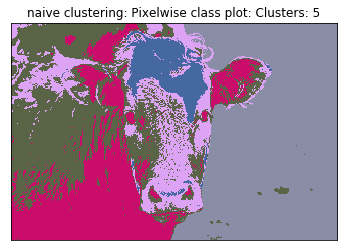

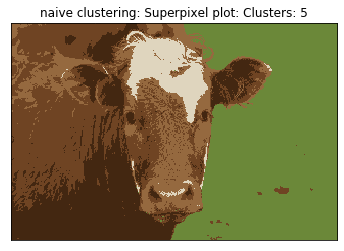

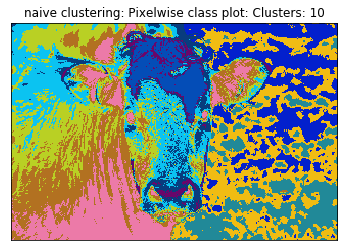

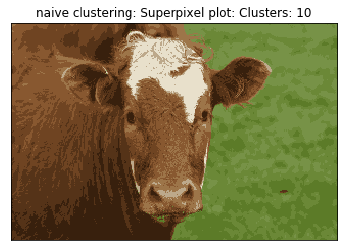

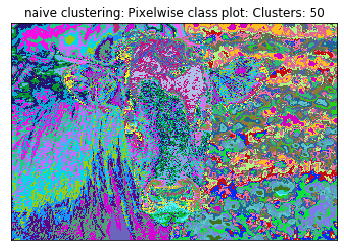

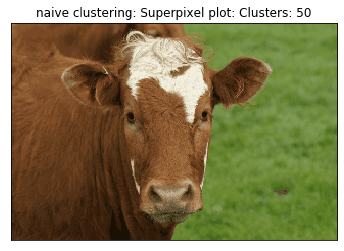

In [6]:
def cluster_pixels(im,k):    
    #TODO Pixelwise clustering   
    #assert 1==2," NOT IMPLEMENTED" 
    #segmap is nXm. Each value in the 2D array is the cluster assigned to that pixel
    #segmap = KMeans(im, k, max_iters = 1000)
    segmap = Kmeans(im,k,max_iters = 1000, channels = 3)
    segmap = np.array(segmap).reshape(im.shape[0], im.shape[1])
    return segmap
for k in [5,10,50]:
    clusters = cluster_pixels(im,k)
    _ = rgb_segment(clusters,n = k, title =  "naive clustering: Pixelwise class plot: Clusters: " + str(k),legend = False)
    superpixel_plot(im,clusters,title =  "naive clustering: Superpixel plot: Clusters: "+ str(k))

###Question 2: Now that you have a function handy, we have a slightly complex task

Instead of making clustering run on RGB space, run the clustering on RGBXY space. What advantages does that give us? 
(try with clusters = 5, 10, 25, 50, 150)

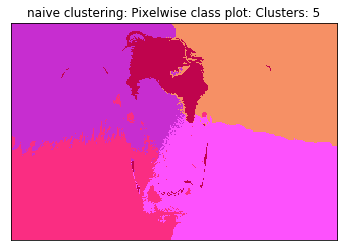

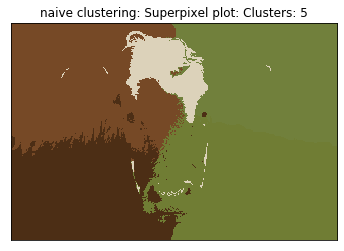

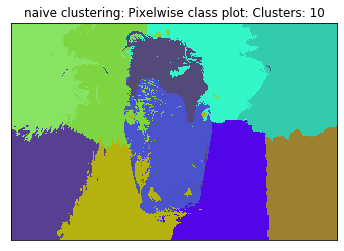

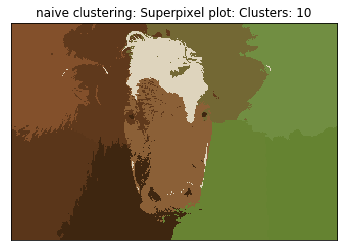

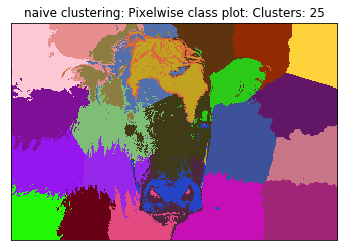

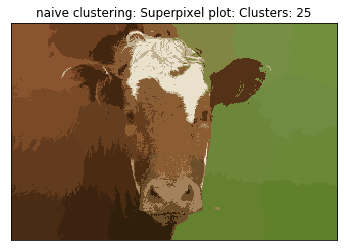

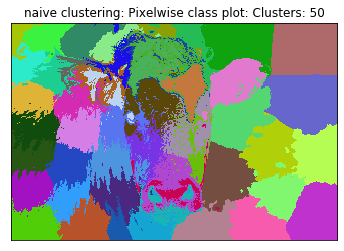

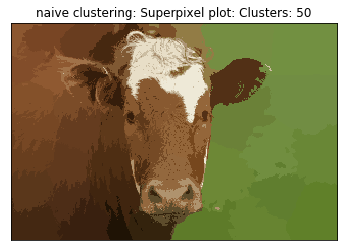

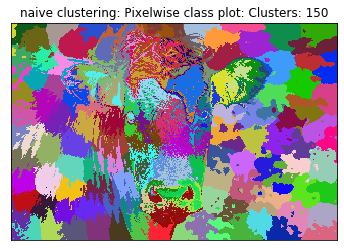

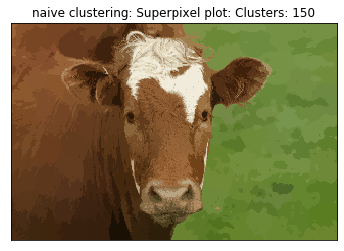

In [7]:
#TODO: clustering r,b,g,x,y values 
#try k = 20,80,200,400,800

def cluster_rgbxy(im,k):
    """
    Given image im and asked for k clusters, return nXm size 2D array
    segmap[0,0] is the class of pixel im[0,0,:]
    """
    #assert 1==2,"NOT IMPLEMENTED"
    # Create the 5D RGBXY space
    # Meshgrid returns the position value matrix for the input image
    x_coord, y_coord = np.meshgrid(np.linspace(0, im.shape[0]-1, num = im.shape[0], dtype = int), 
                                   np.linspace(0, im.shape[1]-1, num = im.shape[1], dtype = int), 
                                   indexing = 'ij')
    # Concatenate depth wise
    image = np.stack((im[:,:,0],im[:,:,1], im[:,:,2], x_coord, y_coord), axis = 2)
    
    segmap = Kmeans(image, k, max_iters=1000, channels = 5)
    segmap = np.array(segmap).reshape(im.shape[0], im.shape[1])
    return segmap

for k in [5,10,25,50,150]:
    clusters = cluster_rgbxy(im,k)
    _ = rgb_segment(clusters,n = k, title =  "naive clustering: Pixelwise class plot: Clusters: " + str(k),legend = False)
    superpixel_plot(im,clusters,title =  "naive clustering: Superpixel plot: Clusters: "+ str(k))


###  Modified k-means with weighted distances. 

 Let $cluster\_center_i$ represent $i^{th}$ cluster center, $cluster\_center_i^{rgb}$ denote the RGB value and $cluster\_center_i^{xy}$ be the corresponding coordinate of the center pixel, respectively.
 
 Let $x_{rgb}$ be the the RGB value of a pixel, and let $x_{xy}$ be the corresponding pixel's coordinate.
 <!-- Let $x_{xy}$ be the coordinate of $x_{rgb}$ -->

$distance(x_{rgb},x_{xy}) = \lambda_1 * euclidean(x_{rgb},cluster\_center_{i}^{rgb})  + \lambda_2 * euclidean(x_{xy},cluster\_center_{i}^{xy})$



Find good values for hyperparmeters $\lambda_1$ and $\lambda_2$ (try on 250 clusters)

In [8]:
def ModifiedKmeans(image, k, lambda_1, lambda_2, max_iters, channels):
    
    # Convert the image to 2D from RGB/RGBXY Space

    pixel_2d = image.reshape(-1,channels)
    
    # Pick indices of k random points
    index = np.random.choice(len(pixel_2d), k, replace = False)
    
    # Initialize the centroids
    k_centroids = pixel_2d[index,:] 
    
    for _ in range(max_iters):
        
        previous_centroids = k_centroids
        
        #Compute the distances. Added the weights lambda 1 and lambda 2 to compute distances between 
        # rgb pixels and cluster center rgb value and xy pixels and cluster center xy values
        
        pixel_distance = (lambda_1 * distance(pixel_2d[:,0:3], previous_centroids[:,0:3], k) 
                          + lambda_2 * distance(pixel_2d[:,3:5], previous_centroids[:,3:5],k))
        
        # Find the closest cluster. Basically returns the indices of the minimum value along the 
        # axis
        labels = np.argmin(pixel_distance, axis = 1)
        
        # Compute the new centroids
        k_centroids = update_centroids(pixel_2d, labels, k)
        
        if np.all(previous_centroids == k_centroids):
            break
    
    return labels

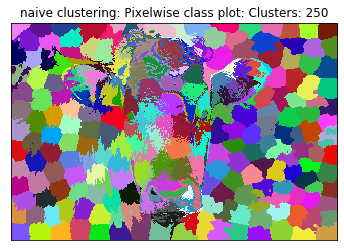

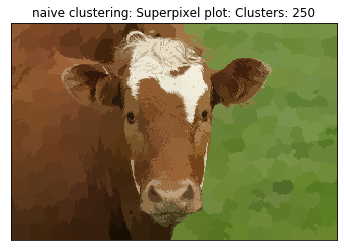

In [9]:
#TODO: clustering r,b,g,x,y values with lambdas and display outputs
def cluster_rgbxy(im,k, lambda_1, lambda_2):
    """
    Given image im and asked for k clusters, return nXm size 2D array
    segmap[0,0] is the class of pixel im[0,0,:]
    """
    x_coord, y_coord = np.meshgrid(np.linspace(0, im.shape[0]-1, num = im.shape[0], dtype = int), 
                                   np.linspace(0, im.shape[1]-1, num = im.shape[1], dtype = int), 
                                   indexing = 'ij')
    # Concatenate depth wise
    image = np.stack((im[:,:,0],im[:,:,1], im[:,:,2], x_coord, y_coord), axis = 2)
    
    segmap = ModifiedKmeans(image, k,  lambda_1, lambda_2, max_iters=1000, channels = 5)
    segmap = np.array(segmap).reshape(im.shape[0], im.shape[1])
    
    #assert 1==2,"NOT IMPLEMENTED"
    return segmap

for k in [250]:
    clusters = cluster_rgbxy(im,k, lambda_1 = 60, lambda_2 = 220)
    _ = rgb_segment(clusters, n = k, title =  "naive clustering: Pixelwise class plot: Clusters: " + str(k),legend = False)
    superpixel_plot(im,clusters,title =  "naive clustering: Superpixel plot: Clusters: "+ str(k))

### HYPERPARAMETERS FOR TESTING

${\lambda_1} = 20, {\lambda_2} = 40$

${\lambda_1} = 40, {\lambda_2} = 80$

${\lambda_1} = 40, {\lambda_2} = 120$

${\lambda_1} = 80, {\lambda_2} = 120$

${\lambda_1} = 80, {\lambda_2} = 180$

${\lambda_1} = 100, {\lambda_2} = 220$ 

${\lambda_1} = 60, {\lambda_2} = 220$

Best Values: ${\lambda_1} = 60, {\lambda_2} = 220$

Looks like whenever I increase the weight on the eucliden distance for the XY Dimension that is ${\lambda_2}$ the algorithm tends to output better superpixels.

###Question 3: SLIC

It doesn't look like we have a very favourable outcome with superpixels simply being implemented as K-means. Can we do better? Have a look at the SLIC paper [here](https://www.iro.umontreal.ca/~mignotte/IFT6150/Articles/SLIC_Superpixels.pdf). Incorporate S and m and redefine your distance metric as per the paper.


In [20]:
#TODO
############Algorithm############
#Compute grid steps: S
#you can explore different values of m
#initialize cluster centers [l,a,b,x,y] using  
#Perturb for minimum G
#while not converged
##for every pixel:
####  compare distance D_s with each cluster center within 2S X 2S. 
####  Assign to nearest cluster
##calculate new cluster center 
 
def SLIC(im, K):
    """
    Input arguments: 
    im: image input
    K: number of cluster segments


    Compute
    S: As described in the paper
    m: As described in the paper (use the same value as in the paper)
    follow the algorithm..
    
    returns:
    segmap: 2D matrix where each value corresponds to the image pixel's cluster number
    """
    k = -1
    
    m = 10 # To control the compactness of a superpixel
    
    # First convert the input image to LAB Colour space if it is in the BGR space
    im = cv2.cvtColor(im, cv2.COLOR_BGR2LAB)
    
    # Now Create the 5D LABXY Space by concatenating the LAB Space with the XY Spatial locations
    x_coord, y_coord = np.meshgrid(np.linspace(0, im.shape[0]-1, num = im.shape[0], dtype = int), 
                                   np.linspace(0, im.shape[1]-1, num = im.shape[1], dtype = int), 
                                   indexing = 'ij')
    # Concatenate depth wise
    image = np.stack((im[:,:,0],im[:,:,1], im[:,:,2], x_coord, y_coord), axis = 2)
    
    # Compute the grid intervals based on number of pixels and cluster segments
    S = int (np.sqrt(im.size / K))

    # Initialize the centroids by sampling pixels at regular grid steps S
    # Size of the centroid is initialized to be K x channels
    centroid_rows = (image.shape[1] // (S)) * (image.shape[0] // (S // 2))
    centroids = np.zeros((centroid_rows, 5))
    #320
    for i in range(S // 2, image.shape[1], S):
        #213
        for j in range(S // 2,image.shape[0], S // 2):
            centroids[k+1,:] = image[j,i,:] 
            k += 1
    return centroids[0,:][0]
    # Perturbation of the initial cluster centers in a 3x3 neighborhood and placing them at the 
    # lowest gradient position to avoid placing them at edges
    for i,c in enumerate(centroids):
        y = c[3]
        x = c[4]
        if x + 1 >= image.shape[0]:
            x = image.shape[0] - 2
        if y + 1 >= image.shape[1]:
            y = image.shape[1] - 2
        current_gradient = (np.square(np.linalg.norm(image[int(x+1),int(y),:][0:3] 
                                                     - image[int(x-1),int(y),:][0:3]))
                            + np.square(np.linalg.norm(image[int(x),int(y+1),:][0:3] 
                                                     - np.linalg.norm(image[int(x),int(y-1),:][0:3]))))
        # Shifting cluster center to the lowest gradient position in an 3x3 neighborhood
        for dx in range(-1,2):
            for dy in range(-1,2):
                # Perturbation
                n_y = y + dy
                n_x = x + dx
                if n_x + 1 >= image.shape[0]:
                    n_x = image.shape[0] - 2
                if n_y + 1 >= image.shape[1]:
                    n_y = image.shape[1] - 2
                n_gradient = (np.square(np.linalg.norm(image[int(n_x+1),int(n_y),:][0:3]
                                                       -image[int(n_x-1),int(n_y),:][0:3]))
                             + np.square(np.linalg.norm(image[int(n_x),int(n_y+1),:][0:3]
                                                        -image[int(n_x),int(n_y-1),:][0:3])))
                if n_gradient < current_gradient:
                    # Change labxy values row wise
                    centroids[i,:] = image[int(n_x),int(n_y),:]
                    current_gradient = n_gradient
    
    # Assignment operation to match the pixels with the best cluster centers in a 2Sx2S region
    for i,c in enumerate(centroids):
        # Initialize the pixel distances with infinity
        distance_pixels = np.full((image.shape[1], image.shape[0]), fill_value=np.inf)
        labels = np.ones
        for x in range(int(c[4] - 2*S), int(c[4] + 2*S)):
            if x < 0 or x > image.shape[0]: continue
            for y in range(int(c[3] - 2*S), int(c[4] + 2*S)):
                if y < 0 or y > image.shape[1]: continue
                    
                    # Distance measures in the LAB Space
                    d_lab = np.sqrt(np.square(c[i,:][0]-image[x,y,:][0])
                                    +np.square(c[i,:][1]-image[x,y,:][1])
                                    +np.square(c[i,:][2]-image[x,y,:][2]))
                    #Distance measure for the XY space
                    d_xy = np.sqrt(np.square(c[i,:][4]-image[x,y,:][4])
                                   +np.square(c[i,:][3]-image[x,y,:][3]))
                    D = d_lab + (m/S)*d_xy
                    
                    if D < distance_pixels[x,y]:
                        distance_pixels[x,y] = D
                        
                        
                        
                    
                
        
x = SLIC(im,250)
x
# return segmap

92.0

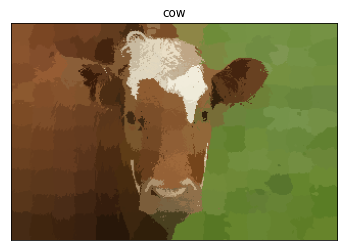

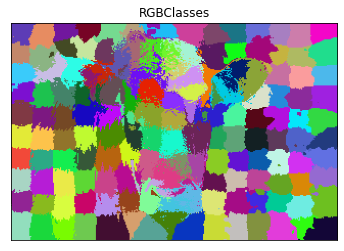

In [ ]:
#TODO diplay your SLIC results.

## Bonus Question:
Enforce connectivity: There are many superpixels which are very small and disconnected from each other. Try to merge them with larger superpixels

O(N) algorithm:
1. Set a minimum size of superpixel
2. If the area of a region is smaller than a threshold, we assign it to the nearest cluster 


In [ ]:
#TODO




## Your File
Link to your colab/ipynb file: **Insert google drive/colab link here**
